In [123]:
import csv
import json
import pandas as pd
pd.options.mode.chained_assignment = None 
from wordcloud import WordCloud
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC

# Pre-processing Data 

### Clean business dataset

In [124]:
business = pd.read_json('yelp_academic_dataset_business.json', lines = True)
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [125]:
# filter out USA restaurant
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
usa=business.loc[business['state'].isin(states)]
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [126]:
# select all restaurants in USA
us_restaurants=usa[usa['categories'].str.contains('Restaurants', na=False)]
# filter out 16 cuisine types of restaurants and rename the category
us_restaurants.is_copy=False
us_restaurants['category']=pd.Series([],dtype=pd.StringDtype())

us_restaurants['category'] = np.where(us_restaurants.categories.str.contains('American'), 'American',
                np.where(us_restaurants.categories.str.contains('Mexican'), 'Mexican',
                np.where(us_restaurants.categories.str.contains('Italian'), 'Italian', 
                np.where(us_restaurants.categories.str.contains('Japanese'), 'Japanese',
                np.where(us_restaurants.categories.str.contains('Chinese'), 'Chinese',
                np.where(us_restaurants.categories.str.contains('Thai'), 'Thai', 
                np.where(us_restaurants.categories.str.contains('Mediterranean'), 'Mediterranean',
                np.where(us_restaurants.categories.str.contains('French'), 'French', 
                np.where(us_restaurants.categories.str.contains('Vietnamese'), 'Vietnamese',
                np.where(us_restaurants.categories.str.contains('Greek'), 'Greek', 
                np.where(us_restaurants.categories.str.contains('Indian'), 'Indian',
                np.where(us_restaurants.categories.str.contains('Korean'), 'Korean', 
                np.where(us_restaurants.categories.str.contains('Hawaiian'), 'Hawaiian',
                np.where(us_restaurants.categories.str.contains('African'), 'African', 
                np.where(us_restaurants.categories.str.contains('Spanish'), 'Spanish', 
                np.where(us_restaurants.categories.str.contains('Middle_eastern'), 'Middle_eastern','null'))))))))))))))))


us_restaurants.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,category
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",null
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...",null
8,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,"{'Caters': 'True', 'Alcohol': 'u'full_bar'', '...","Pubs, Restaurants, Italian, Bars, American (Tr...",None,American
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...",null
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'...",Vietnamese


In [127]:
# drop null values in category, delete original column categories and reset the index
us_restaurants = us_restaurants.drop(us_restaurants[us_restaurants['category'] == 'null'].index, axis=0)
# drop closed restaurant
us_restaurants = us_restaurants.drop(us_restaurants[us_restaurants['is_open'] == 0].index, axis=0)

del us_restaurants['categories']
us_restaurants=us_restaurants.reset_index(drop=True)
us_restaurants.head(10)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,hours,category
0,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'...",Vietnamese
1,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,"{'RestaurantsReservations': 'False', 'Restaura...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ...",American
2,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-...",Japanese
3,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,1,"{'NoiseLevel': 'u'quiet'', 'GoodForMeal': '{'d...","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20...",Korean
4,9OG5YkX1g2GReZM0AskizA,Romano's Macaroni Grill,5505 S Virginia St,Reno,NV,89502,39.476117,-119.789339,2.5,339,1,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",Italian
5,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,901 N Delaware Ave,Philadelphia,PA,19123,39.962582,-75.135657,3.5,65,1,"{'OutdoorSeating': 'True', 'RestaurantsPriceRa...","{'Monday': '0:0-0:0', 'Wednesday': '16:0-22:0'...",American
6,ljxNT9p0y7YMPx0fcNBGig,Tony's Restaurant & 3rd Street Cafe,312 Piasa St,Alton,IL,62002,38.896563,-90.186203,3.0,94,1,"{'RestaurantsReservations': 'True', 'Restauran...","{'Monday': '0:0-0:0', 'Tuesday': '16:0-21:30',...",Italian
7,ABxoFuzZy5mqQ8C5FJJajQ,Core de Roma,201 Jefferson St,Bala Cynwyd,PA,19004,40.028357,-75.238084,5.0,12,1,"{'RestaurantsTakeOut': 'None', 'RestaurantsDel...","{'Tuesday': '15:0-20:30', 'Wednesday': '15:0-2...",Italian
8,seKihQKpGGnCeLuELRQPSQ,Twin Peaks,6880 E 82nd St,Indianapolis,IN,46250,39.906295,-86.047463,3.5,257,1,"{'CoatCheck': 'False', 'Music': '{'dj': False}...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-0:0', '...",American
9,8rb-3VYXE37IZix4yOdskw,Sharky's Sports Bar & Grill,820 N Black Horse Pike,Williamstown,NJ,08094,39.696801,-74.999821,2.5,29,1,"{'Alcohol': 'u'full_bar'', 'RestaurantsGoodFor...",None,American


In [128]:
# check total number of us restaurants
us_restaurants.shape

(18512, 14)

In [129]:
# check whether has duplicated business id
us_restaurants.business_id.duplicated().sum()

0

In [130]:
# check the datatype
us_restaurants.dtypes

business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
attributes       object
hours            object
category         object
dtype: object

In [131]:
## check missing values
us_restaurants.isnull().sum()

business_id        0
name               0
address            0
city               0
state              0
postal_code        0
latitude           0
longitude          0
stars              0
review_count       0
is_open            0
attributes       173
hours           1443
category           0
dtype: int64

### Clean review dataset

In [132]:
# load review table
with  pd.read_json("yelp_academic_dataset_review.json",lines=True, chunksize = 50000) as review_dummy:
    for row in review_dummy:
        review = row;

review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40280 entries, 6950000 to 6990279
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   review_id    40280 non-null  object        
 1   user_id      40280 non-null  object        
 2   business_id  40280 non-null  object        
 3   stars        40280 non-null  int64         
 4   useful       40280 non-null  int64         
 5   funny        40280 non-null  int64         
 6   cool         40280 non-null  int64         
 7   text         40280 non-null  object        
 8   date         40280 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 2.8+ MB


In [133]:
# check missing values
review.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

In [134]:
# check duplicates of review_id
review.review_id.duplicated().sum()

0

### merge business and review dataset

In [135]:
# merge business table and review table
restaurants_reviews = pd.merge(us_restaurants, review, on = 'business_id')
restaurants_reviews.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,review_count,...,hours,category,review_id,user_id,stars_y,useful,funny,cool,text,date
0,49dVbKxmhJ08KGH--9getA,Ramen Sho,"520 S Main St, Ste 96",Meridian,ID,83642,43.60027,-116.392966,4.0,195,...,"{'Monday': '17:0-20:0', 'Tuesday': '17:0-20:0'...",Japanese,P4_HnRpIzf78cyaTti73PA,wsxD7qe4tLcaOp58yMNrWg,5,0,0,0,This Ramen shop is one of the best I've ever b...,2021-01-28 23:22:55
1,49dVbKxmhJ08KGH--9getA,Ramen Sho,"520 S Main St, Ste 96",Meridian,ID,83642,43.60027,-116.392966,4.0,195,...,"{'Monday': '17:0-20:0', 'Tuesday': '17:0-20:0'...",Japanese,pMIAz3_K3tkQIyOiHc7IRg,Hh8Se-AJpaznsxmCA-BqAg,5,2,0,0,Most authentic ramen in Boise (so far)! I'm fr...,2021-01-12 19:50:57
2,49dVbKxmhJ08KGH--9getA,Ramen Sho,"520 S Main St, Ste 96",Meridian,ID,83642,43.60027,-116.392966,4.0,195,...,"{'Monday': '17:0-20:0', 'Tuesday': '17:0-20:0'...",Japanese,zLP0A1Fb3pvIcPMrnoxRug,yrBxqMkCx19SNdd71DpcRA,3,13,3,8,I kind of mulled over this review for the bett...,2019-01-13 07:19:04
3,49dVbKxmhJ08KGH--9getA,Ramen Sho,"520 S Main St, Ste 96",Meridian,ID,83642,43.60027,-116.392966,4.0,195,...,"{'Monday': '17:0-20:0', 'Tuesday': '17:0-20:0'...",Japanese,z0gp1SCpiU40JmXCaSGOog,4BbBngIRETEuXAyVLN0_zg,5,6,3,6,One word: WOW.\nI am truly impressed. \n\nSome...,2020-05-05 14:59:46
4,49dVbKxmhJ08KGH--9getA,Ramen Sho,"520 S Main St, Ste 96",Meridian,ID,83642,43.60027,-116.392966,4.0,195,...,"{'Monday': '17:0-20:0', 'Tuesday': '17:0-20:0'...",Japanese,_02neQ7ijyGSm8oN7iTFxw,IMH47DqVPS1Yeeh0ek3F3g,5,0,0,0,Stopped in for dinner on a Saturday night! Qui...,2020-03-01 01:23:59


In [136]:
## update column names
restaurants_reviews.rename(columns={'stars_x':'avg_star','stars_y':'review_star'}, inplace=True)
restaurants_reviews.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,avg_star,review_count,...,hours,category,review_id,user_id,review_star,useful,funny,cool,text,date
0,49dVbKxmhJ08KGH--9getA,Ramen Sho,"520 S Main St, Ste 96",Meridian,ID,83642,43.60027,-116.392966,4.0,195,...,"{'Monday': '17:0-20:0', 'Tuesday': '17:0-20:0'...",Japanese,P4_HnRpIzf78cyaTti73PA,wsxD7qe4tLcaOp58yMNrWg,5,0,0,0,This Ramen shop is one of the best I've ever b...,2021-01-28 23:22:55
1,49dVbKxmhJ08KGH--9getA,Ramen Sho,"520 S Main St, Ste 96",Meridian,ID,83642,43.60027,-116.392966,4.0,195,...,"{'Monday': '17:0-20:0', 'Tuesday': '17:0-20:0'...",Japanese,pMIAz3_K3tkQIyOiHc7IRg,Hh8Se-AJpaznsxmCA-BqAg,5,2,0,0,Most authentic ramen in Boise (so far)! I'm fr...,2021-01-12 19:50:57
2,49dVbKxmhJ08KGH--9getA,Ramen Sho,"520 S Main St, Ste 96",Meridian,ID,83642,43.60027,-116.392966,4.0,195,...,"{'Monday': '17:0-20:0', 'Tuesday': '17:0-20:0'...",Japanese,zLP0A1Fb3pvIcPMrnoxRug,yrBxqMkCx19SNdd71DpcRA,3,13,3,8,I kind of mulled over this review for the bett...,2019-01-13 07:19:04
3,49dVbKxmhJ08KGH--9getA,Ramen Sho,"520 S Main St, Ste 96",Meridian,ID,83642,43.60027,-116.392966,4.0,195,...,"{'Monday': '17:0-20:0', 'Tuesday': '17:0-20:0'...",Japanese,z0gp1SCpiU40JmXCaSGOog,4BbBngIRETEuXAyVLN0_zg,5,6,3,6,One word: WOW.\nI am truly impressed. \n\nSome...,2020-05-05 14:59:46
4,49dVbKxmhJ08KGH--9getA,Ramen Sho,"520 S Main St, Ste 96",Meridian,ID,83642,43.60027,-116.392966,4.0,195,...,"{'Monday': '17:0-20:0', 'Tuesday': '17:0-20:0'...",Japanese,_02neQ7ijyGSm8oN7iTFxw,IMH47DqVPS1Yeeh0ek3F3g,5,0,0,0,Stopped in for dinner on a Saturday night! Qui...,2020-03-01 01:23:59


In [137]:
# count number of words in each review text 
restaurants_reviews['num_words_review'] = restaurants_reviews.text.str.replace('\n','', regex=True). \
                                          str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','', regex=True).map(lambda x: len(x.split()))
restaurants_reviews.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,avg_star,review_count,...,category,review_id,user_id,review_star,useful,funny,cool,text,date,num_words_review
0,49dVbKxmhJ08KGH--9getA,Ramen Sho,"520 S Main St, Ste 96",Meridian,ID,83642,43.60027,-116.392966,4.0,195,...,Japanese,P4_HnRpIzf78cyaTti73PA,wsxD7qe4tLcaOp58yMNrWg,5,0,0,0,This Ramen shop is one of the best I've ever b...,2021-01-28 23:22:55,43
1,49dVbKxmhJ08KGH--9getA,Ramen Sho,"520 S Main St, Ste 96",Meridian,ID,83642,43.60027,-116.392966,4.0,195,...,Japanese,pMIAz3_K3tkQIyOiHc7IRg,Hh8Se-AJpaznsxmCA-BqAg,5,2,0,0,Most authentic ramen in Boise (so far)! I'm fr...,2021-01-12 19:50:57,29
2,49dVbKxmhJ08KGH--9getA,Ramen Sho,"520 S Main St, Ste 96",Meridian,ID,83642,43.60027,-116.392966,4.0,195,...,Japanese,zLP0A1Fb3pvIcPMrnoxRug,yrBxqMkCx19SNdd71DpcRA,3,13,3,8,I kind of mulled over this review for the bett...,2019-01-13 07:19:04,295
3,49dVbKxmhJ08KGH--9getA,Ramen Sho,"520 S Main St, Ste 96",Meridian,ID,83642,43.60027,-116.392966,4.0,195,...,Japanese,z0gp1SCpiU40JmXCaSGOog,4BbBngIRETEuXAyVLN0_zg,5,6,3,6,One word: WOW.\nI am truly impressed. \n\nSome...,2020-05-05 14:59:46,101
4,49dVbKxmhJ08KGH--9getA,Ramen Sho,"520 S Main St, Ste 96",Meridian,ID,83642,43.60027,-116.392966,4.0,195,...,Japanese,_02neQ7ijyGSm8oN7iTFxw,IMH47DqVPS1Yeeh0ek3F3g,5,0,0,0,Stopped in for dinner on a Saturday night! Qui...,2020-03-01 01:23:59,33


In [138]:
# label reviews as positive or negative
restaurants_reviews['labels'] = ''
restaurants_reviews['labels'] = np.where(restaurants_reviews['review_star'] >= 4, 'positive',
                np.where(restaurants_reviews['review_star'] == 3, 'neural',
                np.where(restaurants_reviews['review_star'] < 3, 'negative', 'null')))

# drop neutral reviews and reset index
restaurants_reviews.drop(restaurants_reviews[restaurants_reviews['labels'] == 'neural'].index, axis=0, inplace=True)
restaurants_reviews.reset_index(drop=True, inplace=True)

restaurants_reviews.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,avg_star,review_count,...,review_id,user_id,review_star,useful,funny,cool,text,date,num_words_review,labels
0,49dVbKxmhJ08KGH--9getA,Ramen Sho,"520 S Main St, Ste 96",Meridian,ID,83642,43.60027,-116.392966,4.0,195,...,P4_HnRpIzf78cyaTti73PA,wsxD7qe4tLcaOp58yMNrWg,5,0,0,0,This Ramen shop is one of the best I've ever b...,2021-01-28 23:22:55,43,positive
1,49dVbKxmhJ08KGH--9getA,Ramen Sho,"520 S Main St, Ste 96",Meridian,ID,83642,43.60027,-116.392966,4.0,195,...,pMIAz3_K3tkQIyOiHc7IRg,Hh8Se-AJpaznsxmCA-BqAg,5,2,0,0,Most authentic ramen in Boise (so far)! I'm fr...,2021-01-12 19:50:57,29,positive
2,49dVbKxmhJ08KGH--9getA,Ramen Sho,"520 S Main St, Ste 96",Meridian,ID,83642,43.60027,-116.392966,4.0,195,...,z0gp1SCpiU40JmXCaSGOog,4BbBngIRETEuXAyVLN0_zg,5,6,3,6,One word: WOW.\nI am truly impressed. \n\nSome...,2020-05-05 14:59:46,101,positive
3,49dVbKxmhJ08KGH--9getA,Ramen Sho,"520 S Main St, Ste 96",Meridian,ID,83642,43.60027,-116.392966,4.0,195,...,_02neQ7ijyGSm8oN7iTFxw,IMH47DqVPS1Yeeh0ek3F3g,5,0,0,0,Stopped in for dinner on a Saturday night! Qui...,2020-03-01 01:23:59,33,positive
4,49dVbKxmhJ08KGH--9getA,Ramen Sho,"520 S Main St, Ste 96",Meridian,ID,83642,43.60027,-116.392966,4.0,195,...,FNh7gQ8wN74D_vZbjXaAag,DzF8BXs2QAv40UuTBZMAWQ,5,0,0,0,Great atmosphere! Great host and staff! Wonder...,2018-04-29 02:56:03,15,positive


# Visulazing Patterns - Exploratory Data Analysis

In [139]:
plt.style.use('seaborn')

### Count Restaurants By Category

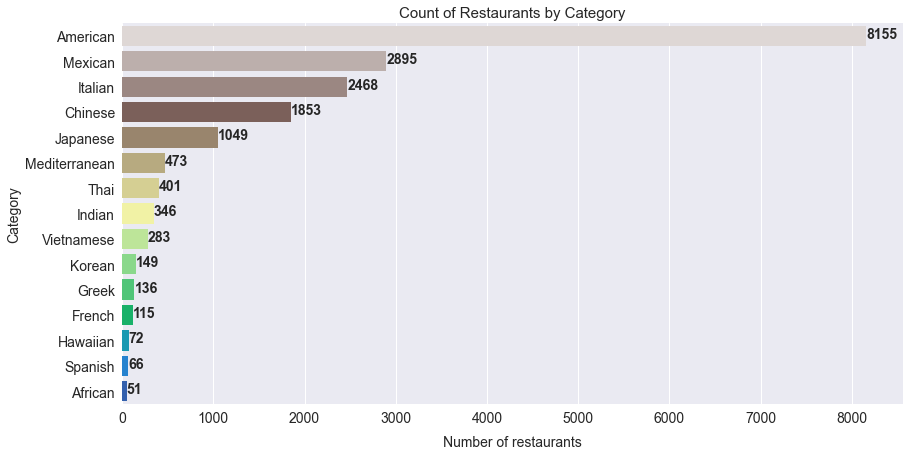

In [140]:
plt.figure(figsize=(14,7))
grouped = us_restaurants.category.value_counts()
sns.countplot(y='category',data=us_restaurants, order = grouped.index, palette= sns.color_palette("terrain_r", len(grouped)))
plt.xlabel('Number of restaurants', fontsize=14, labelpad=10)
plt.ylabel('Category', fontsize=14)
plt.title('Count of Restaurants by Category', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(grouped):
    plt.text(v, i+0.08, str(v),fontweight='bold', fontsize=14)

### Count Restaurants By City (Top 12)

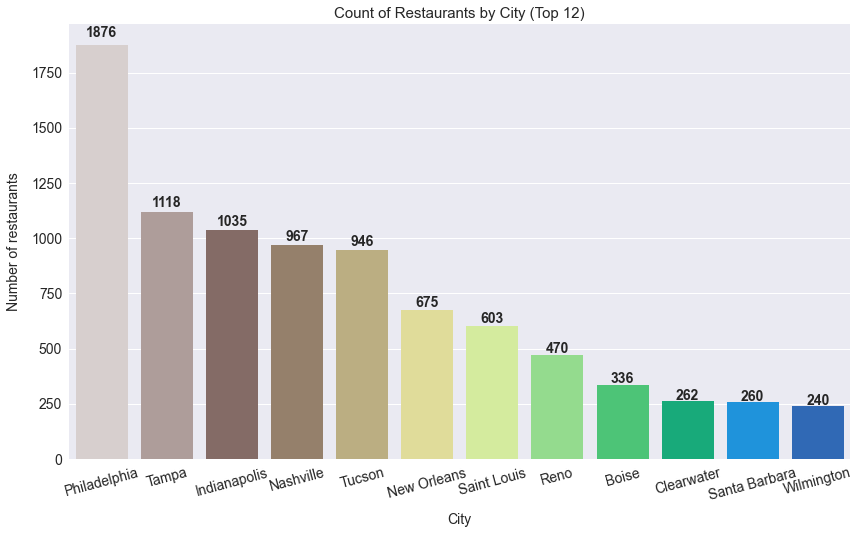

In [141]:
plt.figure(figsize=(14,8))
grouped = us_restaurants.city.value_counts()[:12]
sns.barplot(data=us_restaurants, x=grouped.index, y=grouped.values, palette=sns.color_palette("terrain_r", len(grouped)))

plt.ylabel('Number of restaurants', fontsize=14, labelpad=10)
plt.xlabel('City', fontsize=14, labelpad=10)
plt.title('Count of Restaurants by City (Top 12)', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)

### Distribution of Restaurants in Each State

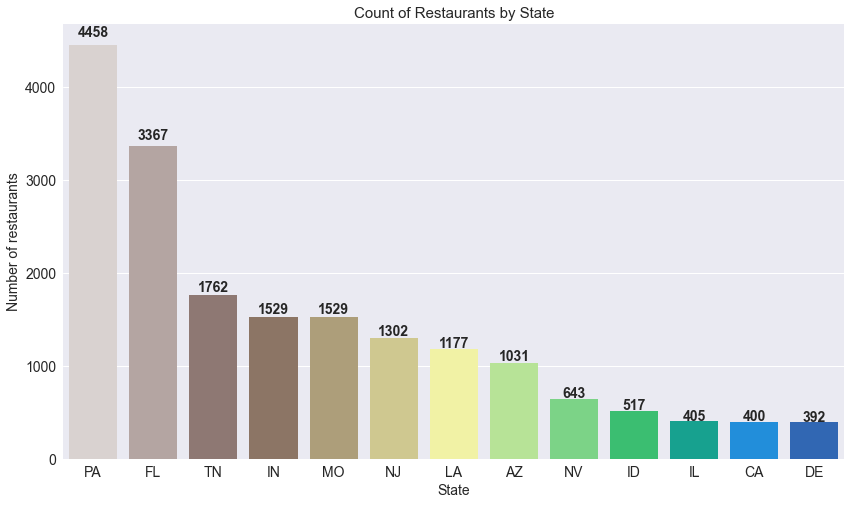

In [142]:
plt.figure(figsize=(14,8))
grouped = us_restaurants.state.value_counts()
sns.barplot(x=grouped.index, y=grouped.values, palette=sns.color_palette("terrain_r", len(grouped)))
plt.ylabel('Number of restaurants', fontsize=14)
plt.xlabel('State', fontsize=14)
plt.title('Count of Restaurants by State', fontsize=15)
plt.tick_params(labelsize=14)
for i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center', fontweight='bold', fontsize=14)

### Distribution of Reviews by Cuisine Type

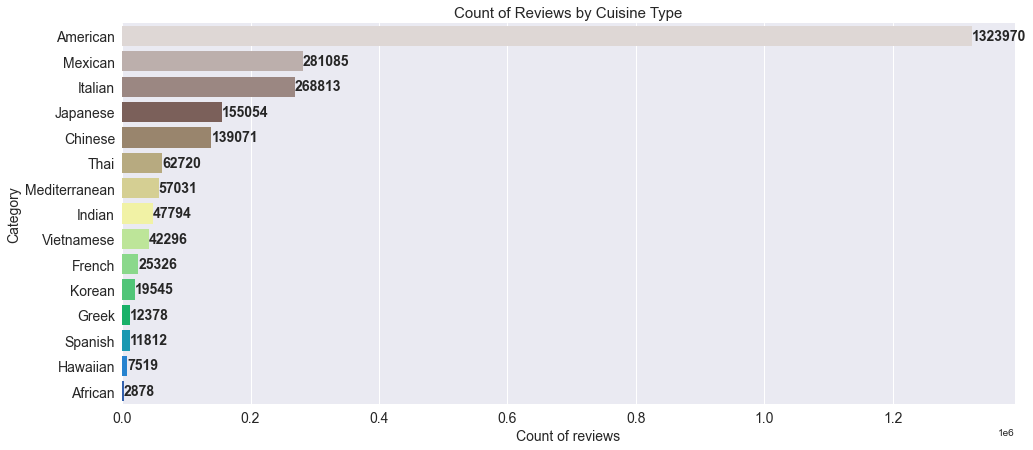

In [143]:
plt.figure(figsize=(16,7))
grouped = us_restaurants.groupby('category')['review_count'].sum().sort_values(ascending = False)
sns.barplot(y=grouped.index, x= grouped.values, palette= sns.color_palette("terrain_r", len(grouped)) )
plt.ylabel('Category', fontsize=14)
plt.xlabel('Count of reviews', fontsize=14)
plt.title('Count of Reviews by Cuisine Type', fontsize=15)
plt.tick_params(labelsize=14)
for i,v in enumerate(grouped):
    plt.text(v, i+0.15, str(v),fontweight='bold', fontsize=14)

### Top 10 Restaurants with Most Reviews

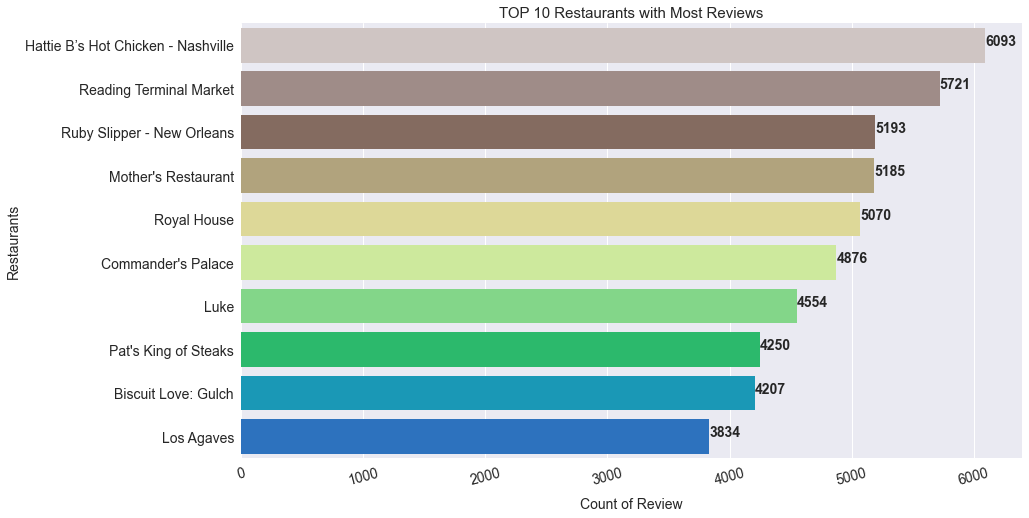

In [144]:
plt.figure(figsize=(14,8))
grouped = us_restaurants[['name','review_count']].sort_values(by='review_count', ascending = False)[:10]
sns.barplot(x=grouped.review_count, y = grouped.name, palette=sns.color_palette("terrain_r", len(grouped)))
plt.xlabel('Count of Review', labelpad=10, fontsize=14)
plt.ylabel('Restaurants', fontsize=14)
plt.title('TOP 10 Restaurants with Most Reviews', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)
for  i, v in enumerate(grouped.review_count):
    plt.text(v, i, str(v), fontweight='bold', fontsize=14)

### Distribution of positive and negative reviews in each category

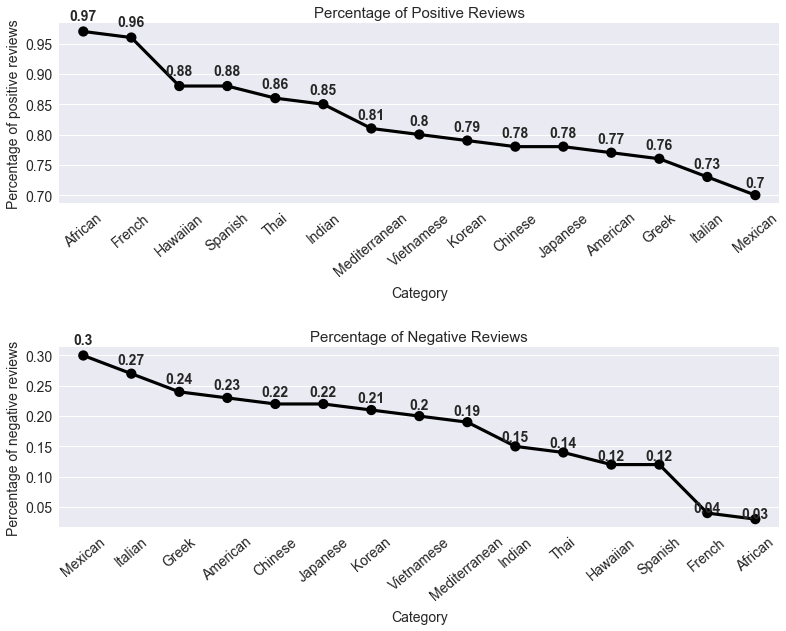

In [145]:
table = pd.pivot_table(restaurants_reviews, values=["review_id"], index=["category"],columns=["labels"], 
                       aggfunc='count', margins=True, fill_value=0)

positive_percentage = table.div(table.iloc[:,-1], axis=0).iloc[:-1,-2].round(2).sort_values(ascending=False)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
plt.subplots_adjust(left=0.5, right=1.5, bottom=0.5, top=1.2, hspace=0.8)
plt.subplot(211)
sns.pointplot(x=positive_percentage.index, y= positive_percentage.values, color='black')
plt.xlabel('Category', labelpad=7, fontsize=14)
plt.ylabel('Percentage of positive reviews', fontsize=14)
plt.title('Percentage of Positive Reviews', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=40)
for  i, v in enumerate(positive_percentage):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)
    
negative_percentage = table.div(table.iloc[:,-1], axis=0).iloc[:-1, -3].round(2).sort_values(ascending=False)
plt.subplot(212)
sns.pointplot(x=negative_percentage.index, y= negative_percentage.values, color='black')
plt.xlabel('Category', labelpad=7, fontsize=14)
plt.ylabel('Percentage of negative reviews', fontsize=14)
plt.title('Percentage of Negative Reviews', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=40)
for  i, v in enumerate(negative_percentage):
    plt.text(i, v*1.06, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)

### Average Rating of each Category

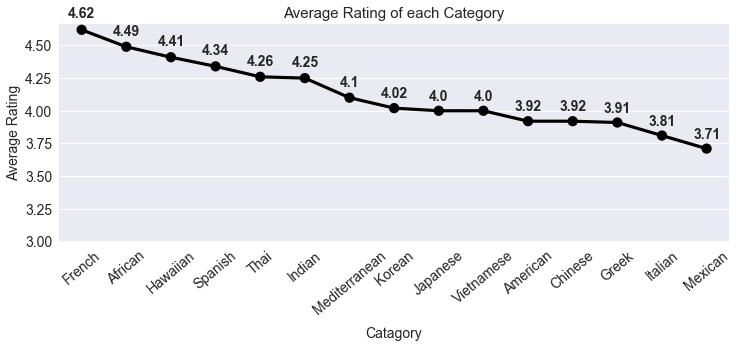

In [146]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,4))
grouped = restaurants_reviews.groupby('category')['review_star'].mean().round(2).sort_values(ascending=False)
sns.pointplot(x = grouped.index, y = grouped.values, color='black')
plt.ylim(3)
plt.xlabel('Catagory', labelpad=10, fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.title('Average Rating of each Category', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=40)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)

### Average length of words in each category

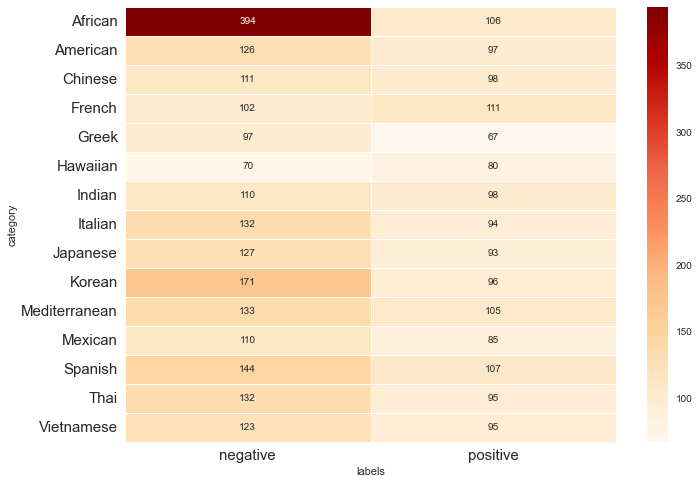

In [147]:
table = restaurants_reviews.groupby(['category','labels'])['num_words_review'].mean().round().unstack()
plt.figure(figsize=(11,8))
sns.heatmap(table, cmap='OrRd', fmt='g',annot=True, linewidths=1)
plt.tick_params(labelsize=15)

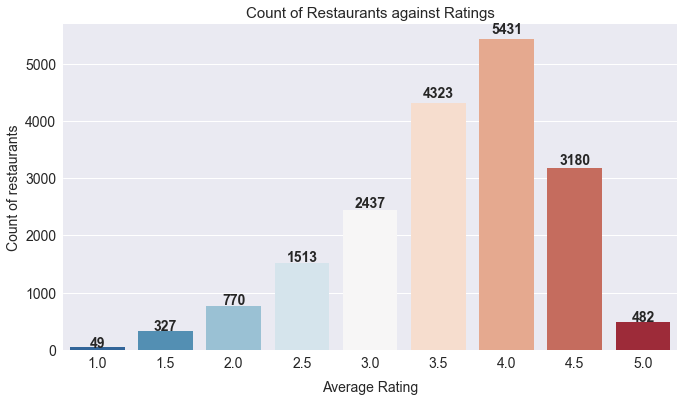

In [148]:
plt.figure(figsize=(11,6))
grouped = us_restaurants.stars.value_counts().sort_index()
sns.barplot(x = grouped.index, y = grouped.values, palette=sns.color_palette("RdBu_r", len(grouped)))
plt.xlabel('Average Rating', labelpad=10, fontsize=14)
plt.ylabel('Count of restaurants', fontsize=14)
plt.title('Count of Restaurants against Ratings', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)

## Review Analysis

In [149]:
# convert text to lower case
restaurants_reviews.text = restaurants_reviews.text.str.lower()

# remove unnecessary punctuations
restaurants_reviews['removed_punct_text'] = restaurants_reviews.text.str.replace('\n', ''). \
                                                str.replace('[!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~]', '', regex=True)


In [150]:
# import positive file which contains common meaningless positive words
file_positive = open('positive.txt')
reader =csv.reader(file_positive)
positive_words = [word[0] for word in reader]

# import negative file which contains common meaningless positive words
file_negative = open('negative.txt')
reader =csv.reader(file_negative)
negative_words = [word[0] for word in reader]

In [151]:
# get dataset by category
def get_dataset(category):
    df = restaurants_reviews[['removed_punct_text','labels']][restaurants_reviews.category==category]
    df.reset_index(drop=True, inplace =True)
    df.rename(columns={'removed_punct_text':'text'}, inplace=True)
    return df

# only keep positive and negative words
def filter_words(review):
    words = [word for word in review.split() if word in positive_words + negative_words]
    words = ' '.join(words)
    return words

### Creating Word Cloud

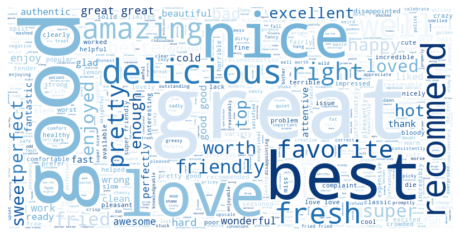

In [152]:
all_reviews = " ".join(review for review in restaurants_reviews.text)
wc = WordCloud(background_color="white", colormap="Blues", max_words=1000,
               width=800, height=400).generate(filter_words(all_reviews))

#show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [254]:
Korean_reviews = get_dataset('Korean')
Korean_train, Korean_test = train_test_split(Korean_reviews[['text','labels']],test_size=0.5)
print('Total %d number of reviews' % Korean_train.shape[0])

Total 45 number of reviews


In [265]:
def split_data(dataset, test_size):
    df_train, df_test = train_test_split(dataset[['text','labels']],test_size=test_size)
    return df_train

In [266]:
# filter words
Korean_train.text = Korean_train.text.apply(filter_words)
# construct features and labels
terms_train=list(Korean_train['text'])
class_train=list(Korean_train['labels'])

terms_test=list(Korean_test['text'])
class_test=list(Korean_test['labels'])
# get bag of words : the frequencies of various words appeared in each review
vectorizer = CountVectorizer()
feature_train_counts=vectorizer.fit_transform(terms_train)
feature_train_counts.shape
# run model
svm = LinearSVC()
svm.fit(feature_train_counts, class_train)

LinearSVC()

In [267]:
# create dataframe for score of each word in a review calculated by svm model
coeff = svm.coef_[0]
Korean_words_score = pd.DataFrame({'score': coeff, 'word': vectorizer.get_feature_names()})

In [268]:
# get frequency of each word in all reviews in specific category
Korean_reviews = pd.DataFrame(feature_train_counts.toarray(), columns=vectorizer.get_feature_names())
Korean_reviews['labels'] = class_train
Korean_frequency = Korean_reviews[Korean_reviews['labels'] =='positive'].sum()[:-1]

In [269]:
Korean_words_score.set_index('word', inplace=True)

In [270]:
Korean_polarity_score = Korean_words_score
Korean_polarity_score['frequency'] = Korean_frequency

In [271]:
# calculate polarity score 
Korean_polarity_score['polarity'] = Korean_polarity_score.score * Korean_polarity_score.frequency / Korean_reviews.shape[0]

In [272]:
# drop unnecessary words
unuseful_positive_words = ['great','amazing','love','best','awesome','excellent','good',
                            'favorite','loved','perfect','gem','perfectly','wonderful',
                            'happy','enjoyed','nice','well','super','like','better','decent','fine',
                            'pretty','enough','excited','impressed','ready','fantastic','glad','right',
                            'fabulous','easy','enjoying','work']

for word in unuseful_positive_words:
    try:
        Korean_polarity_score.drop(word, axis=0, inplace=True)
    except KeyError:
        pass
    
unuseful_negative_words =  ['bad','disappointed','unfortunately','disappointing','horrible',
                            'lacking','terrible','sorry', 'disappoint','fried']

for word in unuseful_negative_words:
    try:
        Korean_polarity_score.drop(word, axis=0, inplace=True)
    except KeyError:
        pass



In [273]:
Korean_polarity_score.polarity = Korean_polarity_score.polarity.astype(float)
Korean_polarity_score.frequency = Korean_polarity_score.frequency.astype(float)

In [274]:
Korean_polarity_score[Korean_polarity_score.polarity>0].sort_values(by='frequency', ascending=False)[:20]

,score,frequency,polarity
word,,,
recommend,0.041810,8.0,0.007433
friendly,0.142590,6.0,0.019012
fun,0.524361,5.0,0.058262
fresh,0.222825,4.0,0.019807
sweet,0.141254,4.0,0.012556
delicious,0.323986,4.0,0.028799
tender,0.119420,3.0,0.007961
work,0.035891,3.0,0.002393
cold,0.153884,3.0,0.010259
